In [71]:
import numpy as np
import time
from scipy.stats import norm
# Import pandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams['animation.embed_limit'] = 200
import matplotlib.animation as animation
from IPython.display import HTML
import os
import fnmatch

In [212]:
lprefix = "../QCBM-compare-grad_and_free/"
ada_folders = (
    "a",
    "b"
)
cob_mmd_folders = (
    ("data/cobyla-Ver-1.00-20240610-213956", (1, 2)),
    ("data/cobyla-Ver-1.00-20240610-214712", (3, 4)),
    ("data/cobyla-Ver-1.00-20240610-214753", (5, 6, 7)),
    ("data/cobyla-Ver-1.00-20240610-214828", (8, 9)),
)
cma_mmd_folders = (
    ("data/cmaes-Ver-1.00-20240610-222919", (1,)),
    ("data/cmaes-Ver-1.00-20240610-222944", (2, 3, 4)),
    ("data/cmaes-Ver-1.00-20240610-223004", (5, 6, 7)),
    ("data/cmaes-Ver-1.00-20240610-223944", (8, 9))
)

In [39]:
for f in os.listdir(prefix + cob_folders[0][0]):
    print(f)

cobyla-Ver-1.00-cobyla_D1-20240610-220425-nfev.txt
cobyla-Ver-1.00-cobyla_D1-20240610-220425-iters.txt
cobyla-Ver-1.00-cobyla_D2-20240610-223931-iters.txt
cobyla-Ver-1.00-cobyla_D2-20240610-223931-par_hist.txt
cobyla-Ver-1.00-QCBM_opt_depth.sh
cobyla-Ver-1.00-cobyla_D2-20240610-223931-fun.txt
cobyla-Ver-1.00-generate_prob_data.py
cobyla-Ver-1.00-cobyla_D1-20240610-220425-par_hist.txt
cobyla-Ver-1.00-prob_data.txt
cobyla-Ver-1.00-cobyla_D2-20240610-223931-x.txt
cobyla-Ver-1.00-cobyla_D2-20240610-223931-cost_history.txt
cobyla-Ver-1.00-QCBM_opt_depth.toml
cobyla-Ver-1.00-cobyla_D1-20240610-220425-fun.txt
cobyla-Ver-1.00-cobyla_D1-20240610-220425-x.txt
cobyla-Ver-1.00-cobyla_D1-20240610-220425-cost_history.txt
cobyla-Ver-1.00-cobyla_D2-20240610-223931-nfev.txt


In [210]:
keywords_cob = (
    "nfev",
    "iters",
    "par_hist",
    "fun",
    "x",
    "cost_history",
)
keywords_ma = (
    "nfev",
    "iters",
    "par_hist",
    "fun",
    "x",
    "cost_history",
)

In [41]:
def get_path(data: tuple, depth: int) -> str:
    for p, ds in data:
        if depth in ds:
            return p
    return None

In [225]:
def get_data(data: tuple, depth: int, keyword: str, prefix: str) -> np.ndarray:
    #prelen = 24
    p = get_path(data=data, depth=depth)
    lf = os.listdir(prefix + p)
    for file in lf:
        if fnmatch.fnmatch(file, '*_D' + str(depth) + '-*-' + keyword + ".txt"):
            return np.loadtxt(prefix + p + '/' + file)
    return None

In [226]:
def get_prob_data(data: tuple, depth: int, prefix: str) -> np.ndarray:
    p = get_path(data=data, depth=depth)
    lf = os.listdir(prefix + p)
    for file in lf:
        if fnmatch.fnmatch(file, "*-prob_data.txt"):
            return np.loadtxt(prefix + p + '/' + file)
    return None

In [227]:
def get_toml_data(data: tuple, depth: int, prefix: str):
    p = get_path(data=data, depth=depth)
    lf = os.listdir(prefix + p)
    for file in lf:
        if fnmatch.fnmatch(file, "*-QCBM_opt_depth.toml"):
            return load_tomlconfig(filename=prefix + p + '/' + file)
    return None

In [228]:
def bin_smooth(bin_size, data):
    rem = (len(data)%bin_size)
    l = len(data)
    m = [np.mean(data[i:i+bin_size]) for i in range(0, len(data)-bin_size)]
    m.extend(data[l-bin_size:l])
    return m

In [234]:
float(get_data(data=cma_mmd_folders, depth=3, keyword="iters", prefix=lprefix))

220.0

In [230]:
get_prob_data(data=cma_mmd_folders, depth=3, prefix=lprefix)

array([4.05715198e-06, 4.14609148e-06, 4.23680105e-06, ...,
       6.61262108e-05, 6.57693833e-05, 6.54137879e-05])

In [134]:
def plot_cost_depths(data: list, L: str, xL: str, yL: str, file: str = None):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    ax.set(ylim=[0.95 * np.min(data), 1.05 * np.max(data)])
    ax.bar(range(1,len(data)+1), data, label=L)
    #ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='data')
    ax.set_ylabel(yL, fontsize=15)
    ax.set_xlabel(xL, fontsize=15)
    plt.legend(title='Legend:')
    if file is not None:
        plt.savefig(file, format='pdf', dpi=150, bbox_inches='tight')
    else:
        plt.show()

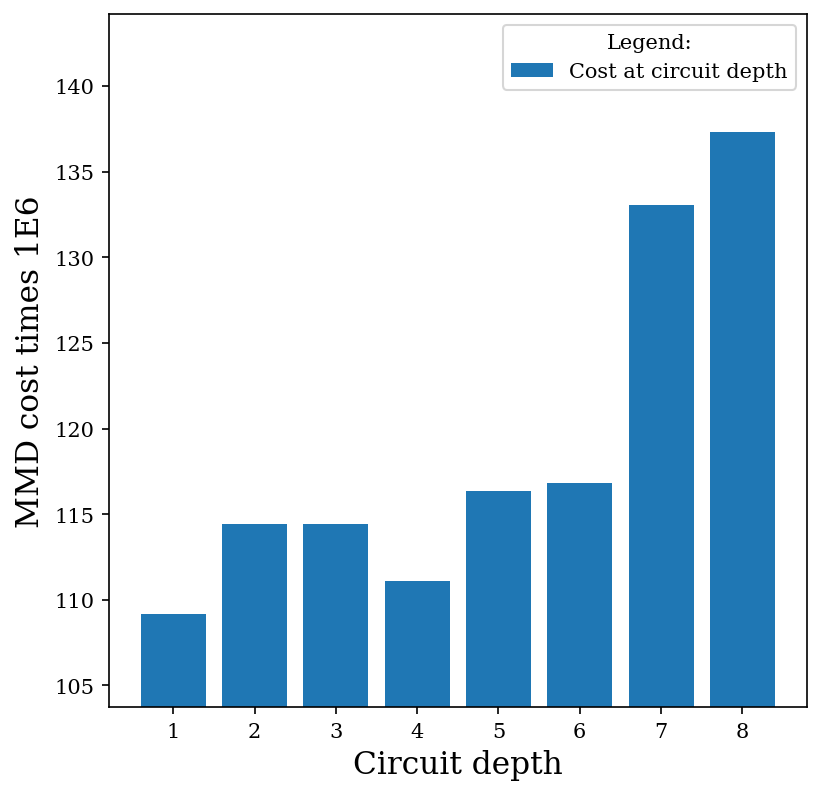

In [238]:
plot_cost_depths(
    data=[
        float(
            get_data(
                data=cma_mmd_folders,
                depth=d, keyword="fun",
                prefix=lprefix
            ) * 1.0e6
        ) for d in range(1,9)
    ],
    L="Cost at circuit depth",
    xL="Circuit depth",
    yL="MMD cost times 1E6",
    file=None,
)

In [136]:
def plot_cost_learning(data: list, L: str, xL: str, yL: str, file: str = None, smooth: int = None):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    ax.plot(range(len(data)), data, label = L)
    if smooth is not None:
        s = bin_smooth(data=data, bin_size=smooth)
        ax.plot(range(len(s)), s, label = L + ' - bined (' + str(smooth) + ')')
    ax.set_ylabel(yL, fontsize=15)
    ax.set_xlabel(xL, fontsize=15)
    plt.legend(title='Legend:')
    if file is not None:
        plt.savefig(file, format='pdf', dpi=150, bbox_inches='tight')
    else:
        plt.show()

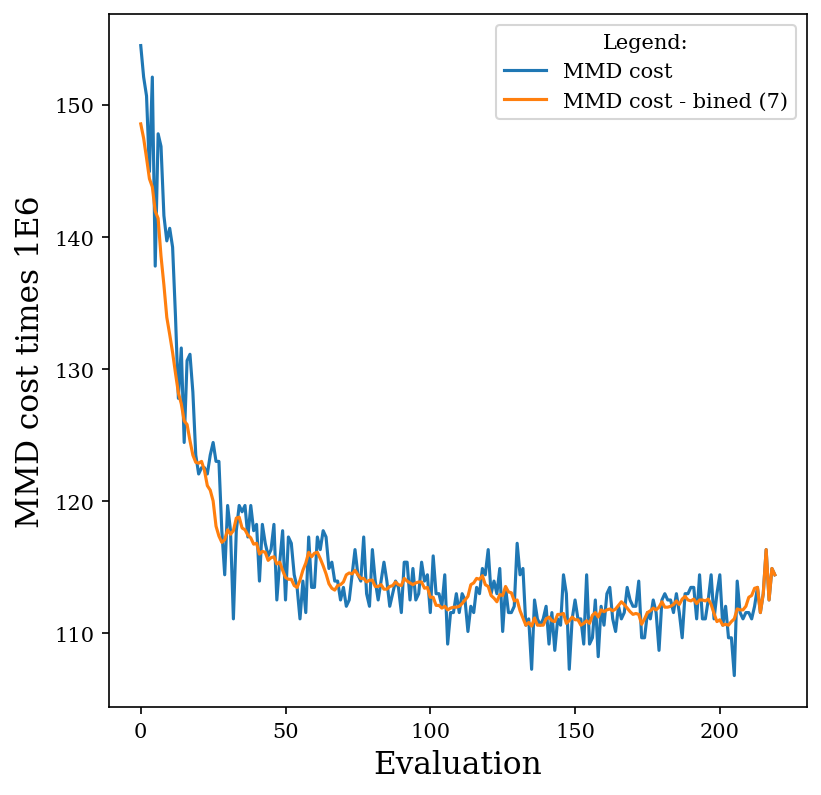

In [232]:
plot_cost_learning(
    data=get_data(
        data=cma_mmd_folders,
        depth=3, keyword="cost_history",
        prefix=lprefix
    ) * 1.0e6,
    L="MMD cost",
    xL="Evaluation",
    yL="MMD cost times 1E6",
    file=None,
    smooth=7
)

In [205]:
def plot_distrs(coord_data: list, bar_data: list, scatter_data: list, bar_L: str, scatter_L: str, xL: str, yL: str, file: str = None):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    ax.bar(coord_data, bar_data, width=0.05, label=bar_L)
    ax.scatter(coord_data, scatter_data, color='crimson', s=12, label=scatter_L)
    ax.set_ylabel(yL, fontsize=15)
    ax.set_xlabel(xL, fontsize=15)
    plt.legend(title='Legend:')
    if file is not None:
        plt.savefig(file, format='pdf', dpi=150, bbox_inches='tight')
    else:
        plt.show()

In [197]:
from QCBM_opt_depth import load_tomlconfig, get_dqc, get_passmanager
from process_data import dist_pdf
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from generate_prob_data import gen_prob_data

In [144]:
tomlcfg = get_toml_data(cob_mmd_folders, depth=3, prefix=lprefix)

Loaded config:
{'cfg_version': '1.00', 'use_ibm_q': False, 'variant': 'cobyla', 'ibm_backend': 'ibm_kyiv', 'num_qubits': 12, 'shots': 3000, 'fake_backend': 'fake_kyiv', 'noise': True, 'use_gpu': True, 'random_seed': 123456, 'depth_min': 3, 'depth_max': 5, 'depths': [3, 4], 'rhobeg': 1.0, 'max_iter': 1000, 'layout_import': [0, 1, 2, 3, 4, 15, 22, 21, 20, 19, 18, 14], 'prob_datafile': 'FourNormalDist-v1.txt', 'cost_variant': 'MMD_torch', 'num_generations': 2, 'layout_file': 'Eagle_r3-circular-lm.toml', 'multi': 0, 'account': 'hudecvl1.fjfi'}


In [151]:
service = QiskitRuntimeService(name='hudecvl1.fjfi')

In [152]:
ibmbackend = service.get_backend(tomlcfg.get("ibm_backend"))

In [155]:
noise_model = NoiseModel.from_backend(ibmbackend)

In [157]:
aer_backend_options = {
    'noise_model': noise_model,
    "seed_simulator": 123456,
    "method": 'density_matrix',
    "device": "GPU",
    "batched_shots_gpu": True,
}

In [160]:
aersampler = AerSampler(
    backend_options=aer_backend_options,
    skip_transpilation=True
)

In [163]:
pm = get_passmanager(
    backend=ibmbackend,
    layout=tomlcfg.get('layout_import')
)

In [244]:
job = aersampler.run(
    circuits=get_dqc(
        cfg=tomlcfg,
        depth=3,
        pm=pm
    ),
    parameter_values=get_data(
        data=cma_mmd_folders,
        depth=3, keyword="x",
        prefix=lprefix
    ),
    shots=5000
)

In [245]:
model = dist_pdf(dist=job.result().quasi_dists[0].nearest_probability_distribution(), maximmum=(2**tomlcfg.get("num_qubits")))

In [171]:
def bin_mean(data, bin_size):
    if (len(data)%bin_size):
        raise ValueError
    bin_data = []
    for i in range(0, len(data), bin_size):
        bin_data.append(np.mean(data[i:i+bin_size]))
    return bin_data

In [243]:
coords = np.linspace(-4, 4, 2**tomlcfg.get("num_qubits"))

In [186]:
len(model)

4096

In [199]:
len(source)

4096

In [198]:
source = gen_prob_data((2**tomlcfg.get("num_qubits")))

In [240]:
source = get_prob_data(
    data=cma_mmd_folders,
    depth=3,
    prefix=lprefix
)

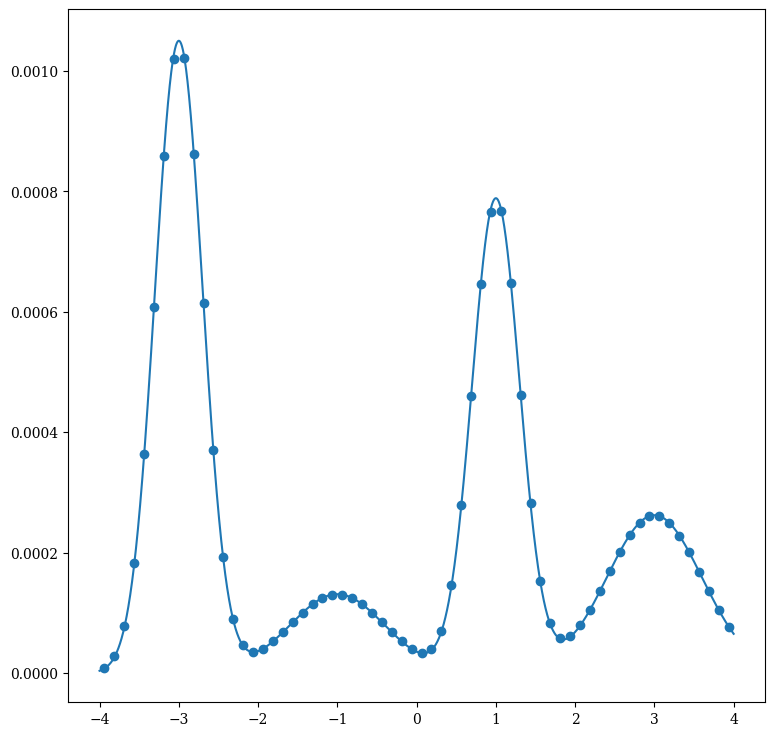

In [239]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(coords, source)
ax.scatter(bin_coords, bin_source)
plt.show()

In [246]:
bin_coords = bin_mean(data=coords, bin_size=64)
bin_model  = bin_mean(data=model , bin_size=64)
bin_source = bin_mean(data=source, bin_size=64)

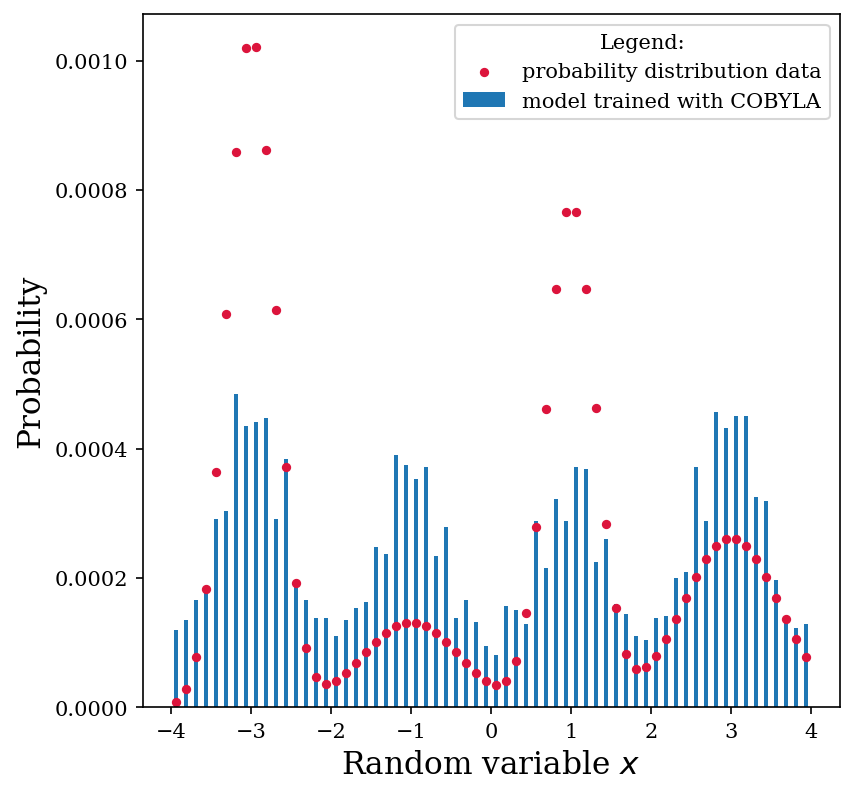

In [247]:
plot_distrs(
    coord_data=bin_coords,
    bar_data=bin_model,
    scatter_data=bin_source,
    bar_L='model trained with COBYLA',
    scatter_L='probability distribution data',
    xL=r'Random variable $x$',
    yL=r'Probability',
    file=None,
)

In [118]:
test = [1,2]
test.extend([2,4,5])
print(test)

[1, 2, 2, 4, 5]


In [235]:
from multishot import *

In [237]:
multilayout = clones_to_layout(
            readlayoutmap(
                filename=cfg.get("layout_file"),
            )[0:multi]
        )
print(f"multilayout: {multilayout}")
aux = {
    "multi": 6,
    "pm": "missing pm"
}
aux.update(
    {
        "passmanager": get_passmanager(
            backend=aux.get("backend"),
            layout=multilayout
        ),
        "multilayout": multilayout
    }
)


In [ ]:
multipm = "missing"